# Support Vector Machine

* ソーシャルメディアから収集した日本語の投稿文に対して、分かち書き＋クリーニング＋正規化+テキスト分類を行っています。

# Google Driveのマウント

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%env HF_TOKEN = #環境変数HF_TOKENにhuggingfaceのトークンをセット
%env FILE_PATH = /content/drive/MyDrive/ #ディレクトリ
%cd /content/drive/MyDrive/ #ディレクトリ

# Python環境の整備

In [ ]:
!pip install neologdn demoji mecab-python3 unidic-lite unidic emoji
!python -m unidic download

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.6/144.6 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.7/581.7 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 MB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.8/433.8 kB 33.9 MB/s eta 0:00:00
  Created wheel for neologdn: filename=neologdn-0.5.3-cp310-cp310-linux_x86_64.whl size=223871 sha256=cbbfd767ce93e1d40697e24d2ccea04697ce2f934f2e7d484379be9c51cc0b5d
  Stored in directory: /root/.cache/pip/wheels/f3/06/cd/3216b1007983e3cde801f6376c641617c37f4f520f9faed644
  Created wheel for unidic-lite: filename=unidic_lite-1.0.8-py3-none-any.whl size=47658818 sha256=0d470a4870197313b0e1067f5ddcaf7ed24e387b717c435069c577a561b25569
  Stored in directory: /root/.ca

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import emoji
import re
import neologdn
import demoji
import MeCab
import numpy as np

# Neologdの指定版 最新語に対応する
# tagger = MeCab.Tagger('-d /usr/lib64/mecab/dic/mecab-ipadic-neologd')

def get_restricted_wakati_list(text):
  # 取り出したい品詞
  select_conditions = ['動詞', '形容詞', '名詞', '副詞']

  # 分かち書きオブジェクト
  tagger = MeCab.Tagger('-Owakati')

  # 分けてノードごとにする
  node = tagger.parseToNode(text)
  terms = []

  while node:
      term = node.surface
      pos = node.feature.split(',')[0]
      if pos in select_conditions:
          terms.append(term)
      node = node.next

  #return terms
  return " ".join(terms)

def wakati_word_list_create(sentences:list, get_word_class:list) -> list:
  #複数文から、指定の品詞(GET_WORD_CLASS)を抽出した単語リスト
  sentences_word_list = []

  for sentence in sentences:
    #一文から、指定の品詞(GET_WORD_CLASS)を抽出した単語リスト
    one_sentence_word_str = ''
    #形態素解析
    node = MeCab.parseToNode(sentence)

    while node:
      #語幹
      word = node.feature.split(",")[-3]
      #品詞
      word_class = node.feature.split(",")[0]
      #(指定の品詞(GET_WORD_CLASS)である) and (語幹が＊のもの(つまり未知語))場合は、単語リストに追加
      if word_class in get_word_class and word != '*':
        one_sentence_word_str = one_sentence_word_str + " " + word
        node = node.next

    sentences_word_list.append(one_sentence_word_str)

  return sentences_word_list

def get_wakati_list(text):
  tagger = MeCab.Tagger('-Owakati')
  node = tagger.parseToNode(text)
  terms = []

  while node:
    term = node.surface
    terms.append(term)
    node = node.next

  return terms

def clean_text_preprocess(text):
  replaced_text = text.lower().replace("&gt;", ">").replace("&lt;", "<").replace("&amp;", "&")
  replaced_text = re.sub(r'[@＠]\w+', '', replaced_text)            # メンションの除去
  replaced_text = re.sub(r'(@.*)', '', replaced_text)             # ロケーション除去
  replaced_text = re.sub(r'https?://[\w/:%#\$&\?\(\)~\.=\+\-]+', '', replaced_text)  # URLの除去
  replaced_text = re.sub(r'[&＆э〓■●＿～□◯○┳┻≡◎θゝ゚ヽ゚ゞ彡ヾ゜ｱﾞ￣ 凸凹○ﾍ ｺｯ┤、，,├⊂⊃;-ω-\)∩⊃｡ｏ0ε＝┏┛＜∧|uιｰ↓→↑←⇒■□◇◆△▲▽▼＾＾: (´д`~ﾉ∠※.:*:\'° ﾟ／/☆★♪♪⌒.°「」｢｣〔〕“”〈〉＜＞《》≪≫『』【】【】＆＊・（）＄＃＠。、？？！｀＋￥％～（；＿；）＼‥…!！＋\+]', ' ', replaced_text)
  replaced_text = replaced_text.replace("www", '')
  replaced_text = re.sub(r'　', ' ', replaced_text)                  # 全角空白の除去
  replaced_text = re.sub(r'[\uFF01-\uFF0F\uFF1A-\uFF20\uFF3B-\uFF40\uFF5B-\uFF65\u3000-\u303F\u3094]', '', replaced_text)
  replaced_text = replaced_text.replace('\n','').replace('\r','')   # 改行除去
  replaced_text = demoji.replace(string = replaced_text, repl = '') # 絵文字除去
  replaced_text = re.sub(r'\d+', '0', replaced_text)                  # 数字を0に置き換え
  replaced_text = re.sub(r'\b\d{1,3}(,\d{3})*\b', '0', replaced_text) # 数字を0に置き換え
  replaced_text = re.sub(r'(^RT.*) ', '', replaced_text, flags=re.MULTILINE | re.DOTALL)  # retweetを除去
  replaced_text = re.sub(r'#', '', replaced_text)     # ハッシュタグの#のみ除去
  replaced_text = neologdn.normalize(replaced_text)  # 正規化

  return get_restricted_wakati_list(replaced_text)
  #return replaced_text

# カテゴリリスト
categories = [ 'T', 'F' ]
categories_dic = { 'T' : 0, 'F' : 1}
categories_dic2 = { 0 : 'T', 1 : 'F' }

# データの読込
data_df = pd.read_csv(f"{os.environ['FILE_PATH']}/tweets_201704_202209_20240314.csv",encoding='cp932')
data_df = data_df.drop(columns=data_df.columns[0])
data_df['text after preprocessing'] = data_df['text'].apply(clean_text_preprocess)
data_df = data_df.rename(columns = { 'text after preprocessing' : 'sentence' }) # 前処理後の文
#data_df = data_df.rename(columns = { 'text' : 'sentence' }) # 元の文

# データ抽出(train, validation)
train_df = data_df.loc[0:16223,  ["sentence", "label"]]         # .replace("F", 1).replace("T", 0)
validation_df = data_df.loc[16224:21631, ["sentence", "label"]] # .replace("F", 1).replace("T", 0)
test_df = data_df.loc[21632:27039, ["sentence", "label"]]       # .replace("F", 1).replace("T", 0)

train_cat = np.array([categories_dic.get(doc) for doc in train_df['label']], dtype=np.int64)
test_cat = np.array([categories_dic.get(doc) for doc in test_df['label']], dtype=np.int64)
train_words = [doc for doc in train_df['sentence']]
test_words = [doc for doc in test_df['sentence']]

In [ ]:
train_df

,sentence,label
0,名古屋 昼 暑い 感じ 夜 少し 肌寒かっ する,F
1,電車 座る 時 大抵 隣 人 もたれかかっ 寝 くる 暑い,F
2,暑い 日 串揚げ 流し込み 居酒屋 縁,F
3,今日 暑い,T
4,大須 買い物 きょう 暑い しばし 休憩 エアコン つい,T
...,...,...
16219,今日 暑い タピオカ レモン シャーベット 大須 亜細亜 坊 タピオカ からあげ 大須 商店...,F
16220,暑い 悪夢 うなされ 起き しまう 夕方 バイト 省エネ モード 切り替え,T
16221,暑い 買っ,T
16222,めっちゃ 暑い 散歩 行け,T


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

text_clf = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', MultinomialNB()),
])

text_clf = text_clf.fit(train_words, train_cat) # 学習
predicted = text_clf.predict(test_words) # 推定

np.mean(predicted == test_cat)

0.7272559171597633

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn import metrics

text_clf_sgd = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42)),
])

text_clf_sgd = text_clf_sgd.fit(train_words, train_cat)
sgd_predicted = text_clf_sgd.predict(test_words)

print(metrics.classification_report(test_cat, predicted, target_names = categories, digits=4))

              precision    recall  f1-score   support

           T     0.6877    0.8226    0.7491      2677
           F     0.7847    0.6338    0.7012      2731

    accuracy                         0.7273      5408
   macro avg     0.7362    0.7282    0.7252      5408
weighted avg     0.7367    0.7273    0.7249      5408



正解率（Accuracy） = 72.73%
適合率（Precision） = 78.47%
再現率（Recall） = 63.38%
F1値（F1-score） = 70.12%


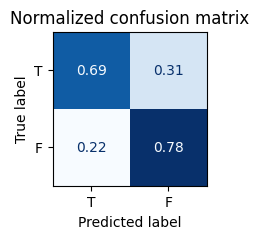

In [ ]:
precision, recall, f1_score, _ = precision_recall_fscore_support(test_cat, predicted, average="binary")

print('正解率（Accuracy） = {:.2f}%'.format(100 * accuracy_score(test_cat, predicted))) # 正解率を表示
print('適合率（Precision） = {:.2f}%'.format(100 * precision)) # 適合率を表示
print('再現率（Recall） = {:.2f}%'.format(100 * recall)) # 再現率を表示
print('F1値（F1-score） = {:.2f}%'.format(100 * f1_score)) #F1値を表示

labels = ['T', 'F']
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(2, 2))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

plot_confusion_matrix(test_cat, predicted, labels)